In [85]:
using CARMA
using DelimitedFiles
using Ensemble
using HDF5
using Printf
using PyPlot
using PyCall
using Statistics

sns = pyimport("seaborn")
sns.set_context("notebook")
sns.set_palette("colorblind")
sns.set_style("ticks")

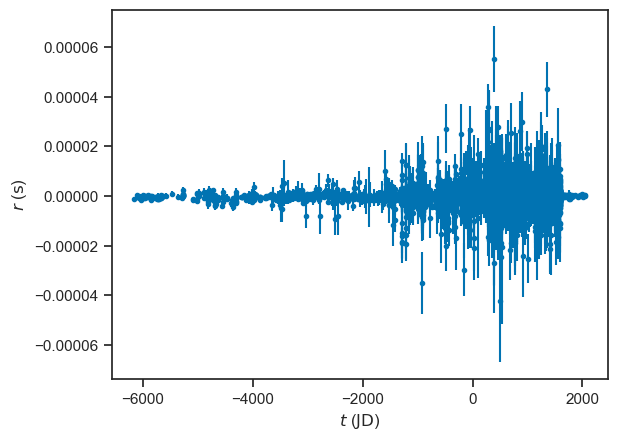

PyObject Text(29.0, 0.5, '$r$ ($\\mathrm{s}$)')

In [8]:
d = readdlm("DR2/release/VersionA/J1713+0747/residuals.dat")
errorbar(d[:,1], d[:,2], d[:,3], fmt=".")
xlabel(L"$t$ ($\mathrm{JD}$)")
ylabel(L"$r$ ($\mathrm{s}$)")

In [27]:
inds = sortperm(d[:,1])
ts = Float64[]
rs = Float64[]
drs = Float64[]

tlast = d[inds[1],1]
rlast = d[inds[1],2]
drlast = d[inds[1],3]
for (t, r, dr) in zip(d[inds[2:end],1], d[inds[2:end],2], d[inds[2:end],3])
    if t > tlast
        push!(ts, tlast)
        push!(rs, rlast)
        push!(drs, drlast)
        
        tlast = t
        rlast = r
        drlast = dr
    else
        rlast = (rlast/(drlast*drlast) + r/(dr*dr))/(1.0/(drlast*drlast)+1.0/(dr*dr))
        drlast = sqrt(1.0/(1.0/(drlast*drlast) + 1.0/(dr*dr)))
    end
end

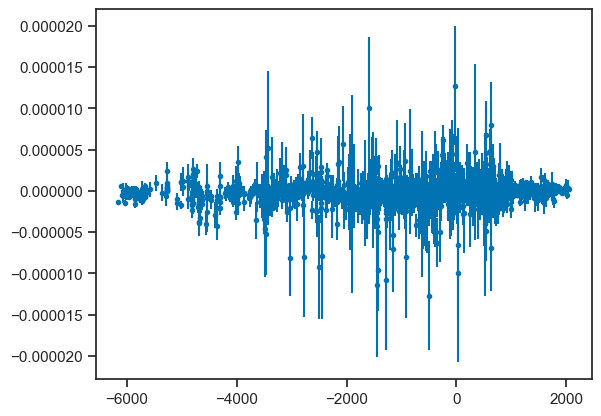

(PyObject <matplotlib.lines.Line2D object at 0x147fd4828>, (), (PyObject <matplotlib.collections.LineCollection object at 0x148006518>,))

In [28]:
errorbar(ts, rs, drs, fmt=".")

In [35]:
post = Kalman.CARMAKalmanPosterior(ts, rs, drs, 3, 2)
ns = EnsembleNest.NestState(x -> Kalman.log_likelihood(post, x), x->Kalman.log_prior(post, x), Kalman.init(post, 1024), 32);

In [36]:
EnsembleNest.run!(ns, 0.1, verbose=false, ckpt_file="J1713.ckpt")

Save the state to `J1713.ns`; if you don't want to run the sampler above, you can always re-load the state from `J1713.ns`.

In [38]:
h5open("J1713.ns", "w") do f
    write(f, ns)
end

1.0

In [44]:
ps, logls = EnsembleNest.postsample(ns)

([-3.7071168800962446e-7 -7.442385424759777e-6 … -2.0085696240108874e-7 -2.3046994036983972e-7; 7.120044906629232e-7 2.219752298444002e-6 … 3.17225373969524e-7 3.4906594785899644e-7; … ; -0.29154081432773005 0.9913944160942965 … 5.166426774080127 1.2775907910237008; 14.05620511812029 -2.281457560858171 … 5.287796852075493 -2.9799184547509427], [42395.97662909606, 42398.899594021306, 42399.41859845205, 42399.42332944852, 42399.48955786487, 42399.8977450208, 42400.00680980051, 42400.04908948051, 42400.40139869575, 42400.676145592006  …  42421.5815359984, 42421.393483859305, 42421.73794529644, 42421.341040636435, 42421.85818353486, 42422.103495974545, 42421.38121017546, 42422.840633743464, 42421.285625976714, 42422.83803645325])

In [57]:
fs = Kalman.psdfreq(post)
fs = exp.(range(log(minimum(fs)), stop=log(maximum(fs)), length=1024))
Ps = Array{Float64,1}[]
for j in 1:size(ps,2)
    push!(Ps, Kalman.psd(post, ps[:,j], fs))
end
Ps = hcat(Ps...);

In [63]:
m = median(Ps, dims=2)
h = zeros(size(Ps, 1))
l = zeros(size(Ps, 1))
for i in 1:size(Ps, 1)
    h[i] = quantile(vec(Ps[i,:]), 0.84)
    l[i] = quantile(vec(Ps[i,:]), 0.16)
end

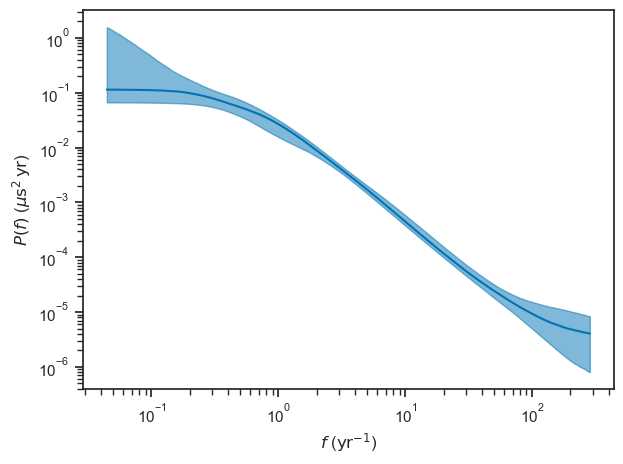

In [67]:
loglog(fs*365.25, median(Ps, dims=2)*1e12/365.25)
fill_between(fs*365.25, h*1e12/365.25, l*1e12/365.25, alpha=0.5, color=sns.color_palette()[1])
xlabel(L"$f$ ($\mathrm{yr}^{-1}$)")
ylabel(L"$P(f)$ ($\mu\mathrm{s}^2 \, \mathrm{yr}$)")

tight_layout()
savefig("J1713.pdf")

There doesn't seem to be much structure in the residuals after the red-noise model is done.  `whiten` uses the fitted CARMA model to whiten the time series to iid  $N(0,1)$.

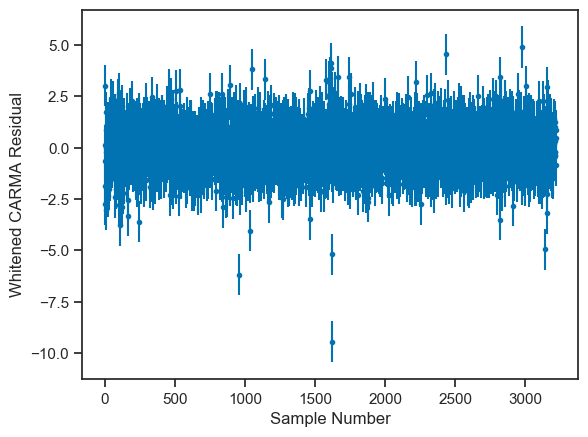

PyObject Text(25.000000000000014, 0.5, 'Whitened CARMA Residual')

In [88]:
j = rand(1:size(ps,2))
wr = Kalman.whiten(post, ps[:,j])
errorbar(collect(1:size(resid,1)), wr, ones(length(wr)), fmt=".")
xlabel("Sample Number")
ylabel("Whitened CARMA Residual")

Here is the ACF of the tempo2 residuals, followed by the ACF of the residuals of the CARMA-whitened residual.  You can see that the CARMA model has eliminated a lot of structure in the residuals, though it's not clear that there isn't still some structure remaining.

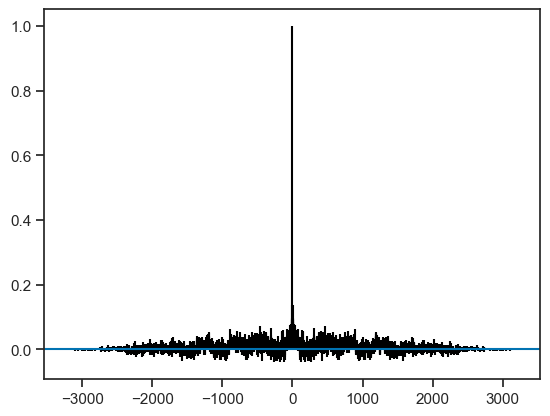

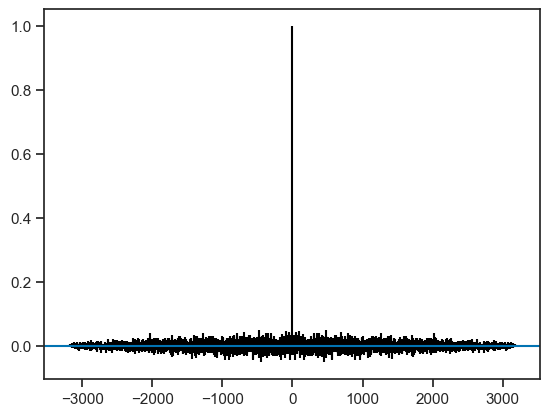

In [89]:
acorr(rs, maxlags=nothing, label="Raw Residuals")
figure()
acorr(Kalman.whiten(post, ps[:,j]), maxlags=nothing);

The RMS timing residual after removing (as much as possible) the correlated noise:

In [102]:
println(@sprintf("CARMA-residual RMS is %.2g microseconds", std(1e6*Kalman.residuals(post, ps[:,j])[1])))

iyr = argmin(abs.(fs*365.25 .- 1))
println(@sprintf("sqrt(f*P(f)) = %.2g microseconds at f = 1 / yr", sqrt(mean(Ps[iyr,:]*1e12/365.25))))

CARMA-residual RMS is 1.1 microseconds
sqrt(f*P(f)) = 0.16 microseconds at f = 1 / yr
